In [89]:
pip install xgboost optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [130]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score, cohen_kappa_score, davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
# from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRegressor
# from catboost import CatBoostClassifier

import optuna 

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/TS-S3-Ep5/train.csv'
file_key_2 = 'Tabular-Playground-Series/TS-S3-Ep5/test.csv'
file_key_3 = 'Tabular-Playground-Series/TS-S3-Ep5/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

## Enginering features
# train['total_acid'] = train['fixed acidity'] + train['volatile acidity'] + train['citric acid']
# train['acid/density'] = train['total_acid']  / train['density']
train['alcohol_density'] = train['alcohol'] * train['density']
train['sulphate/density'] = train['sulphates']  / train['density']
# train['sulphates/acid'] = train['sulphates'] / train['volatile acidity']
# train['sulphates/chlorides'] = train['sulphates'] / train['chlorides']
# train['sulphates*alcohol'] = train['sulphates'] / train['alcohol']
train['alcohol_sulphate'] = train['alcohol'] * train['sulphates']
train['pH_round'] = train['pH'].round(1)
# train['citric_acid_per_alcohol'] = np.where(train['alcohol'] == 0, 0, train['citric acid'] / train['alcohol'])

alcohol_mean_groupby_pH = pd.DataFrame(train.groupby('pH_round')['alcohol'].mean())
alcohol_mean_groupby_pH.columns = ['mean_alcohol_by_pH_round']
alcohol_mean_groupby_pH['pH_round'] = alcohol_mean_groupby_pH.index
alcohol_mean_groupby_pH = alcohol_mean_groupby_pH.reset_index(drop = True)

train = pd.merge(train, alcohol_mean_groupby_pH, on = 'pH_round', how = 'left')


test['alcohol_density'] = test['alcohol']  * test['density']
test['sulphate/density'] = test['sulphates']  / test['density']
test['alcohol_sulphate'] = test['alcohol'] * test['sulphates']

test['pH_round'] = test['pH'].round(1)

alcohol_mean_groupby_pH = pd.DataFrame(test.groupby('pH_round')['alcohol'].mean())
alcohol_mean_groupby_pH.columns = ['mean_alcohol_by_pH_round']
alcohol_mean_groupby_pH['pH_round'] = alcohol_mean_groupby_pH.index
alcohol_mean_groupby_pH = alcohol_mean_groupby_pH.reset_index(drop = True)

test = pd.merge(test, alcohol_mean_groupby_pH, on = 'pH_round', how = 'left')


test_md = test.copy()

X = train[['sulphate/density', 'alcohol_density', 'alcohol', 'sulphates', 'pH_round', 'mean_alcohol_by_pH_round']]
Y = train['quality'] 

test_md = test_md[['sulphate/density', 'alcohol_density', 'alcohol', 'sulphates', 'pH_round', 'mean_alcohol_by_pH_round']]

In [ ]:
pca = PCA()
    pca.fit(X)
    explained_variance = pca.explained_variance_ratio_
    num_components = np.arange(len(explained_variance)) + 1
    # Plot the elbow graph
    x = [1, 2, 3, 4]
    fig, ax = plt.subplots(figsize=(12,5))
    plt.plot(num_components, explained_variance, 'ro-')
    ax.xaxis.set_ticks(x)
    plt.xlabel("Number of Components")
    plt.ylabel("Explained Variance (%)")
    plt.show()

In [128]:
train['pH_round'].value_counts()

3.3    544
3.4    486
3.2    462
3.5    216
3.1    179
3.6     90
3.0     49
3.7     18
3.8      6
2.9      5
2.7      1
Name: pH_round, dtype: int64

In [129]:
test['pH_round'].value_counts()

3.4    376
3.3    347
3.2    314
3.5    122
3.1    102
3.6     53
3.0     32
3.7     15
2.9      5
3.8      2
3.9      2
4.0      1
2.7      1
Name: pH_round, dtype: int64

In [121]:
train.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,total_acid,acid/density,alcohol_density,sulphate/density,sulphates/acid,sulphates/chlorides,sulphates*alcohol,alcohol_sulphate,pH_round,citric_acid_per_alcohol,mean_alcohol_by_pH_round
0,0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6,8.89,8.928213,12.048212,0.773310,1.540000,10.547945,0.063636,9.317,3.3,0.032231,10.440993
1,1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6,10.33,10.345104,12.781312,0.670980,2.233333,7.282609,0.052344,8.576,3.3,0.057031,10.440993
2,2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7,7.64,7.666065,11.261580,0.732490,1.431373,12.372881,0.064602,8.249,3.5,0.002655,10.417824
3,3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5,9.19,9.214880,9.773540,0.531435,0.609195,6.309524,0.054082,5.194,3.2,0.022449,10.270202
4,4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6,9.16,9.211214,9.447180,1.367604,3.777778,17.215190,0.143158,12.920,3.2,0.031579,10.270202


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


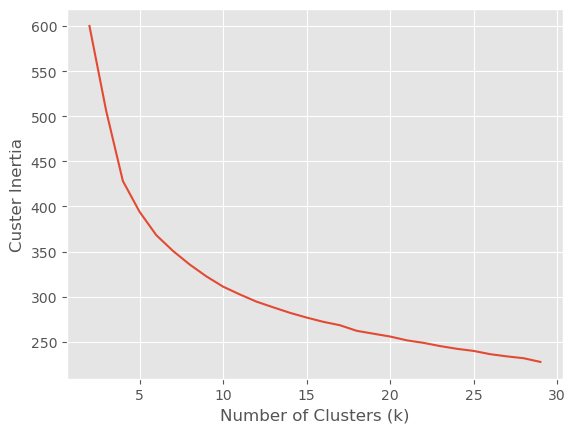

In [122]:
scaler = MinMaxScaler()

# X = train[['sulphate/density', 'alcohol_density', 'alcohol', 'sulphates', 'pH_round']]
X = train.drop(columns = ['Id', 'quality'], axis = 1)
X_trans = scaler.fit_transform(X)

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

## Defining the number of clusters to be considered
krange = list(range(2, 30))

## Defining lists to store scores
CH_scores, DB_scores, silhouette_scores = list(), list(), list()
inertias = list()

for i in krange:
    print(i)
    ## Here we define the k-means model
    cluster_md = KMeans(n_clusters = i, n_init = 20).fit(X_trans)
    cluster_assignments = cluster_md.labels_
    inertias.append(cluster_md.inertia_)
    
    ## Here we extract CH, DB and silhoutte scores
    CH = calinski_harabasz_score(X_trans, cluster_assignments)
    DB = davies_bouldin_score(X_trans, cluster_assignments)
    silhouette = silhouette_score(X_trans, cluster_assignments)
    
    ## Storing scores
    CH_scores.append(CH)
    DB_scores.append(DB)
    silhouette_scores.append(silhouette)

plt.plot(krange, inertias)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Custer Inertia')
plt.show()

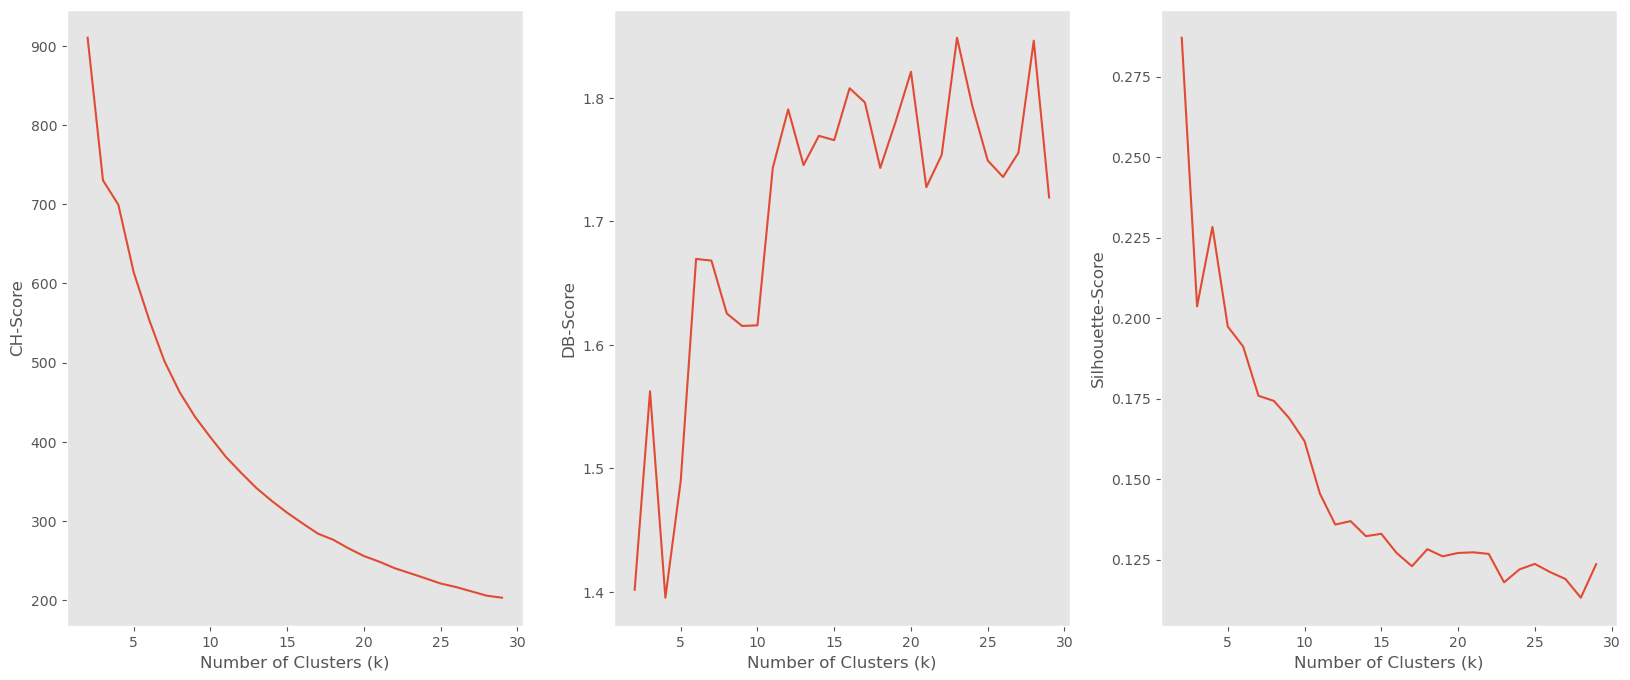

In [123]:
fig, axs = plt.subplots(1, 3, figsize = (20, 8))
axs[0].plot(krange, CH_scores)
axs[0].set_xlabel('Number of Clusters (k)')
axs[0].set_ylabel('CH-Score')
axs[0].grid()

axs[1].plot(krange, DB_scores)
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('DB-Score')
axs[1].grid()

axs[2].plot(krange, silhouette_scores)
axs[2].set_xlabel('Number of Clusters (k)')
axs[2].set_ylabel('Silhouette-Score')
axs[2].grid()

# Optimal Rounder

In [131]:
from functools import partial
import numpy as np
import scipy as sp

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 3
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 4
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 5
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 6
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 7
            else:
                X_p[i] = 8

        ll = cohen_kappa_score(y, X_p, weights = 'quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [3.5, 4.5, 5.5, 6.5, 7.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method = 'nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 3
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 4
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 5
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 6
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 7
            else:
                X_p[i] = 8
        return X_p

    def coefficients(self):
        return self.coef_['x']

# Optuna Optimzation

In [132]:
def objective(trial):
    
    ## Parameters to be evaluated
    param = dict(objective = 'reg:absoluteerror',
                 eval_metric = 'mae',
                 tree_method = 'hist', 
                 random_state = 42,
                 max_depth = trial.suggest_int('max_depth', 2, 10),
                 learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log = True),
                 n_estimators = trial.suggest_int('n_estimators', 30, 10000),
                 gamma = trial.suggest_float('gamma', 0, 10),
                 min_child_weight = trial.suggest_int('min_child_weight', 1, 100),
                 colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 0.9),
                 subsample = trial.suggest_float('subsample', 0.2, 0.9)
                )

    scores = []

#     skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    skf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, Y)):
        
        print(fold, end = ' ')
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        Y_train , Y_valid = Y.iloc[train_idx] , Y.iloc[valid_idx]

        model = XGBRegressor(**param).fit(X_train, Y_train)

        preds_train = model.predict(X_train)
        preds_valid = model.predict(X_valid)
        
        optR = OptimizedRounder()
        optR.fit(preds_train, Y_train)
        coef = optR.coefficients()
        preds_valid = optR.predict(preds_valid, coef).astype(int)
        
        score = cohen_kappa_score(Y_valid,  preds_valid, weights = "quadratic")
        scores.append(score)
        
    return np.mean(scores)

In [133]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 50, timeout = 3600)

[I 2023-02-09 02:08:21,374] A new study created in memory with name: no-name-148afd87-64f3-460f-8e19-dd612ca2383c


0 1 2 3 4 

[I 2023-02-09 02:08:43,198] Trial 0 finished with value: 0.5042048007943939 and parameters: {'max_depth': 6, 'learning_rate': 0.00045261913470540923, 'n_estimators': 991, 'gamma': 6.157750107350495, 'min_child_weight': 25, 'colsample_bytree': 0.7163137067564145, 'subsample': 0.5073612070412958}. Best is trial 0 with value: 0.5042048007943939.


0 1 2 3 4 

[I 2023-02-09 02:09:01,302] Trial 1 finished with value: 0.351965158254239 and parameters: {'max_depth': 8, 'learning_rate': 0.00043234111617735846, 'n_estimators': 857, 'gamma': 4.036027644617719, 'min_child_weight': 4, 'colsample_bytree': 0.7780118581942761, 'subsample': 0.4481743886490416}. Best is trial 0 with value: 0.5042048007943939.


0 1 2 3 4 

[I 2023-02-09 02:09:22,852] Trial 2 finished with value: 0.5201768523518538 and parameters: {'max_depth': 4, 'learning_rate': 0.0003988387595629122, 'n_estimators': 978, 'gamma': 6.015706277059661, 'min_child_weight': 35, 'colsample_bytree': 0.30047168092089144, 'subsample': 0.6675304303139573}. Best is trial 2 with value: 0.5201768523518538.


0 1 2 3 4 

[I 2023-02-09 02:09:56,635] Trial 3 finished with value: 0.49032964000352897 and parameters: {'max_depth': 9, 'learning_rate': 0.013488584465058915, 'n_estimators': 4295, 'gamma': 5.116322456856468, 'min_child_weight': 36, 'colsample_bytree': 0.4910401738817971, 'subsample': 0.8206044330666376}. Best is trial 2 with value: 0.5201768523518538.


0 1 2 3 4 

[I 2023-02-09 02:10:22,345] Trial 4 finished with value: 0.4980558332404009 and parameters: {'max_depth': 8, 'learning_rate': 0.0005532633003090279, 'n_estimators': 2388, 'gamma': 3.503089383528697, 'min_child_weight': 84, 'colsample_bytree': 0.40549363524334425, 'subsample': 0.8664428319916586}. Best is trial 2 with value: 0.5201768523518538.


0 1 2 3 4 

[I 2023-02-09 02:10:45,155] Trial 5 finished with value: 0.47452956404338753 and parameters: {'max_depth': 7, 'learning_rate': 0.00859317083813768, 'n_estimators': 734, 'gamma': 7.288310803381879, 'min_child_weight': 37, 'colsample_bytree': 0.8785399397108367, 'subsample': 0.2986421398855496}. Best is trial 2 with value: 0.5201768523518538.


0 1 2 3 4 

[I 2023-02-09 02:11:11,800] Trial 6 finished with value: 0.5103262631250587 and parameters: {'max_depth': 4, 'learning_rate': 0.002464747510479261, 'n_estimators': 4578, 'gamma': 6.730094062875765, 'min_child_weight': 43, 'colsample_bytree': 0.6488839071566126, 'subsample': 0.5281750339357419}. Best is trial 2 with value: 0.5201768523518538.


0 1 2 3 4 

[I 2023-02-09 02:11:43,964] Trial 7 finished with value: 0.4917260369318967 and parameters: {'max_depth': 10, 'learning_rate': 0.05735220496653951, 'n_estimators': 9834, 'gamma': 7.085701789117235, 'min_child_weight': 73, 'colsample_bytree': 0.4747357255700767, 'subsample': 0.31954959802711413}. Best is trial 2 with value: 0.5201768523518538.


0 1 2 3 4 

[I 2023-02-09 02:12:14,111] Trial 8 finished with value: 0.48520626459983607 and parameters: {'max_depth': 4, 'learning_rate': 0.001176282786016261, 'n_estimators': 5309, 'gamma': 8.282044115231015, 'min_child_weight': 22, 'colsample_bytree': 0.6857818044469169, 'subsample': 0.41977028608929556}. Best is trial 2 with value: 0.5201768523518538.


0 1 2 3 4 

[I 2023-02-09 02:12:48,841] Trial 9 finished with value: 0.47240708841388707 and parameters: {'max_depth': 3, 'learning_rate': 0.010521139537022101, 'n_estimators': 9476, 'gamma': 5.240614983728555, 'min_child_weight': 67, 'colsample_bytree': 0.7005700660792067, 'subsample': 0.5444185740539329}. Best is trial 2 with value: 0.5201768523518538.


0 1 2 3 4 

[I 2023-02-09 02:13:23,307] Trial 10 finished with value: 0.5111579541629585 and parameters: {'max_depth': 2, 'learning_rate': 0.00011532639710089187, 'n_estimators': 6880, 'gamma': 1.230518067062465, 'min_child_weight': 98, 'colsample_bytree': 0.25053301959736407, 'subsample': 0.6958436775342121}. Best is trial 2 with value: 0.5201768523518538.


0 1 2 3 4 

[I 2023-02-09 02:13:51,533] Trial 11 finished with value: 0.502443881940631 and parameters: {'max_depth': 2, 'learning_rate': 0.00010219589630758308, 'n_estimators': 7152, 'gamma': 0.6451800064723381, 'min_child_weight': 100, 'colsample_bytree': 0.2201067086032978, 'subsample': 0.7103943684578886}. Best is trial 2 with value: 0.5201768523518538.


0 1 2 3 4 

[I 2023-02-09 02:14:20,795] Trial 12 finished with value: 0.5284302821369959 and parameters: {'max_depth': 5, 'learning_rate': 0.00011540098159641986, 'n_estimators': 7707, 'gamma': 9.309305391706507, 'min_child_weight': 56, 'colsample_bytree': 0.24247732053633186, 'subsample': 0.6664491194084398}. Best is trial 12 with value: 0.5284302821369959.


0 1 2 3 4 

[I 2023-02-09 02:14:48,987] Trial 13 finished with value: 0.5122260346240632 and parameters: {'max_depth': 5, 'learning_rate': 0.00021370757886566134, 'n_estimators': 7919, 'gamma': 9.498877707720348, 'min_child_weight': 58, 'colsample_bytree': 0.3280699666466076, 'subsample': 0.649964744631724}. Best is trial 12 with value: 0.5284302821369959.


0 1 2 3 4 

[I 2023-02-09 02:15:17,995] Trial 14 finished with value: 0.5219221597246371 and parameters: {'max_depth': 5, 'learning_rate': 0.00023441556355929786, 'n_estimators': 2834, 'gamma': 9.992287299504051, 'min_child_weight': 52, 'colsample_bytree': 0.3078176263967659, 'subsample': 0.6306461511196884}. Best is trial 12 with value: 0.5284302821369959.


0 1 2 3 4 

[I 2023-02-09 02:15:37,278] Trial 15 finished with value: 0.5263775039772339 and parameters: {'max_depth': 6, 'learning_rate': 0.00015835750092792628, 'n_estimators': 2982, 'gamma': 9.925040280373294, 'min_child_weight': 53, 'colsample_bytree': 0.20260190238899242, 'subsample': 0.59463180458969}. Best is trial 12 with value: 0.5284302821369959.


0 1 2 3 4 

[I 2023-02-09 02:16:11,707] Trial 16 finished with value: 0.5246795328853058 and parameters: {'max_depth': 6, 'learning_rate': 0.0011670609278370647, 'n_estimators': 6129, 'gamma': 8.761216106774654, 'min_child_weight': 65, 'colsample_bytree': 0.22001562419180343, 'subsample': 0.7679106503188496}. Best is trial 12 with value: 0.5284302821369959.


0 1 2 3 4 

[I 2023-02-09 02:16:38,069] Trial 17 finished with value: 0.507116370253 and parameters: {'max_depth': 7, 'learning_rate': 0.00010146913905066026, 'n_estimators': 3266, 'gamma': 8.41626526381472, 'min_child_weight': 78, 'colsample_bytree': 0.39662481685763473, 'subsample': 0.599083774109741}. Best is trial 12 with value: 0.5284302821369959.


0 1 2 3 4 

[I 2023-02-09 02:17:25,967] Trial 18 finished with value: 0.5300012664785901 and parameters: {'max_depth': 5, 'learning_rate': 0.00021958759063632168, 'n_estimators': 8167, 'gamma': 9.815108124991168, 'min_child_weight': 57, 'colsample_bytree': 0.20247051186516785, 'subsample': 0.8963316740481351}. Best is trial 18 with value: 0.5300012664785901.


0 1 2 3 4 

[I 2023-02-09 02:18:00,168] Trial 19 finished with value: 0.49624505672062347 and parameters: {'max_depth': 5, 'learning_rate': 0.00025862607751458945, 'n_estimators': 8377, 'gamma': 8.239804466454146, 'min_child_weight': 83, 'colsample_bytree': 0.5803186293104808, 'subsample': 0.8550907063665235}. Best is trial 18 with value: 0.5300012664785901.


0 1 2 3 4 

[I 2023-02-09 02:18:29,693] Trial 20 finished with value: 0.5133616473374059 and parameters: {'max_depth': 3, 'learning_rate': 0.0007159816538887359, 'n_estimators': 8617, 'gamma': 9.162593914482196, 'min_child_weight': 61, 'colsample_bytree': 0.3708269098814799, 'subsample': 0.7777641994198267}. Best is trial 18 with value: 0.5300012664785901.


0 1 2 3 4 

[I 2023-02-09 02:19:15,320] Trial 21 finished with value: 0.5326174560283946 and parameters: {'max_depth': 7, 'learning_rate': 0.00014943382293955388, 'n_estimators': 5905, 'gamma': 9.377503225675342, 'min_child_weight': 58, 'colsample_bytree': 0.20653293256995398, 'subsample': 0.8978657961927203}. Best is trial 21 with value: 0.5326174560283946.


0 1 2 3 4 

[I 2023-02-09 02:20:04,657] Trial 22 finished with value: 0.521831030164085 and parameters: {'max_depth': 7, 'learning_rate': 0.0002147359589235725, 'n_estimators': 6424, 'gamma': 7.825916818464605, 'min_child_weight': 44, 'colsample_bytree': 0.26529282443767027, 'subsample': 0.8933634724300725}. Best is trial 21 with value: 0.5326174560283946.


0 1 2 3 4 

[I 2023-02-09 02:20:43,392] Trial 23 finished with value: 0.5306394723717501 and parameters: {'max_depth': 5, 'learning_rate': 0.00018560534990284052, 'n_estimators': 5675, 'gamma': 8.980545156971663, 'min_child_weight': 72, 'colsample_bytree': 0.2770275275085955, 'subsample': 0.8903187236145252}. Best is trial 21 with value: 0.5326174560283946.


0 1 2 3 4 

[I 2023-02-09 02:21:16,940] Trial 24 finished with value: 0.5289208394868198 and parameters: {'max_depth': 8, 'learning_rate': 0.00032282849849011745, 'n_estimators': 5544, 'gamma': 8.979841069424303, 'min_child_weight': 71, 'colsample_bytree': 0.2896860862063714, 'subsample': 0.8203946242531157}. Best is trial 21 with value: 0.5326174560283946.


0 1 2 3 4 

[I 2023-02-09 02:21:53,117] Trial 25 finished with value: 0.5335883869565885 and parameters: {'max_depth': 7, 'learning_rate': 0.0001812177588829213, 'n_estimators': 4228, 'gamma': 9.995778472456966, 'min_child_weight': 93, 'colsample_bytree': 0.21266483414979495, 'subsample': 0.892568158510844}. Best is trial 25 with value: 0.5335883869565885.


0 1 2 3 4 

[I 2023-02-09 02:22:21,201] Trial 26 finished with value: 0.4962223566398286 and parameters: {'max_depth': 9, 'learning_rate': 0.0007631753813114138, 'n_estimators': 4053, 'gamma': 7.850886289195237, 'min_child_weight': 90, 'colsample_bytree': 0.3482091720310103, 'subsample': 0.772889828674909}. Best is trial 25 with value: 0.5335883869565885.


0 1 2 3 4 

[I 2023-02-09 02:23:01,901] Trial 27 finished with value: 0.5287412539844365 and parameters: {'max_depth': 7, 'learning_rate': 0.0001879460431847782, 'n_estimators': 5953, 'gamma': 8.899778893407127, 'min_child_weight': 90, 'colsample_bytree': 0.27763305378993053, 'subsample': 0.8489847388218621}. Best is trial 25 with value: 0.5335883869565885.


0 1 2 3 4 

[I 2023-02-09 02:23:23,231] Trial 28 finished with value: 0.5128236858740733 and parameters: {'max_depth': 9, 'learning_rate': 0.0003744236046665105, 'n_estimators': 4900, 'gamma': 7.7767110853854415, 'min_child_weight': 77, 'colsample_bytree': 0.333411228261101, 'subsample': 0.8985627033396169}. Best is trial 25 with value: 0.5335883869565885.


0 1 2 3 4 

[I 2023-02-09 02:23:49,125] Trial 29 finished with value: 0.5019695325111417 and parameters: {'max_depth': 6, 'learning_rate': 0.0004908726263932697, 'n_estimators': 2063, 'gamma': 9.04302827191699, 'min_child_weight': 92, 'colsample_bytree': 0.4302297983609997, 'subsample': 0.8102040021453004}. Best is trial 25 with value: 0.5335883869565885.


0 1 2 3 4 

[I 2023-02-09 02:24:18,804] Trial 30 finished with value: 0.5243112689128091 and parameters: {'max_depth': 6, 'learning_rate': 0.00015551054655011596, 'n_estimators': 3859, 'gamma': 9.416737125056502, 'min_child_weight': 82, 'colsample_bytree': 0.2699868237065842, 'subsample': 0.747914092045291}. Best is trial 25 with value: 0.5335883869565885.


0 1 2 3 4 

[I 2023-02-09 02:24:56,576] Trial 31 finished with value: 0.5352919338788799 and parameters: {'max_depth': 5, 'learning_rate': 0.000270134857298064, 'n_estimators': 6862, 'gamma': 9.905195130197818, 'min_child_weight': 66, 'colsample_bytree': 0.217733651517636, 'subsample': 0.8948103134892086}. Best is trial 31 with value: 0.5352919338788799.


0 1 2 3 4 

[I 2023-02-09 02:25:42,328] Trial 32 finished with value: 0.5372966959358523 and parameters: {'max_depth': 7, 'learning_rate': 0.00030697583041108936, 'n_estimators': 6953, 'gamma': 9.934624092061162, 'min_child_weight': 64, 'colsample_bytree': 0.2562969531245944, 'subsample': 0.8403593057310367}. Best is trial 32 with value: 0.5372966959358523.


0 1 2 3 4 

[I 2023-02-09 02:26:28,951] Trial 33 finished with value: 0.5392774376073499 and parameters: {'max_depth': 8, 'learning_rate': 0.00033309336466060566, 'n_estimators': 6869, 'gamma': 9.815617437392243, 'min_child_weight': 21, 'colsample_bytree': 0.20359391322581583, 'subsample': 0.8384068440062318}. Best is trial 33 with value: 0.5392774376073499.


0 1 2 3 4 

[I 2023-02-09 02:26:54,270] Trial 34 finished with value: 0.4940156483345023 and parameters: {'max_depth': 8, 'learning_rate': 0.0003167623350696325, 'n_estimators': 7196, 'gamma': 9.814759496306142, 'min_child_weight': 5, 'colsample_bytree': 0.3382450867058975, 'subsample': 0.826583194916941}. Best is trial 33 with value: 0.5392774376073499.


0 1 2 3 4 

[I 2023-02-09 02:27:44,372] Trial 35 finished with value: 0.542387181135103 and parameters: {'max_depth': 10, 'learning_rate': 0.00038335440199808356, 'n_estimators': 8997, 'gamma': 9.824298168657974, 'min_child_weight': 22, 'colsample_bytree': 0.24137733355645757, 'subsample': 0.7990993576890345}. Best is trial 35 with value: 0.542387181135103.


0 1 2 3 4 

[I 2023-02-09 02:28:35,223] Trial 36 finished with value: 0.5397015117435581 and parameters: {'max_depth': 10, 'learning_rate': 0.0005007004280912661, 'n_estimators': 9059, 'gamma': 8.60790034821735, 'min_child_weight': 19, 'colsample_bytree': 0.30083105317337966, 'subsample': 0.8020055291368684}. Best is trial 35 with value: 0.542387181135103.


0 1 2 3 4 

[I 2023-02-09 02:29:19,226] Trial 37 finished with value: 0.5218788604880757 and parameters: {'max_depth': 10, 'learning_rate': 0.0004882595994551123, 'n_estimators': 9189, 'gamma': 8.471990004667042, 'min_child_weight': 21, 'colsample_bytree': 0.29516833134903003, 'subsample': 0.7305198860101381}. Best is trial 35 with value: 0.542387181135103.


0 1 2 3 4 

[I 2023-02-09 02:29:55,350] Trial 38 finished with value: 0.4808506482667177 and parameters: {'max_depth': 10, 'learning_rate': 0.00076321218595904, 'n_estimators': 8848, 'gamma': 6.3278055524009105, 'min_child_weight': 12, 'colsample_bytree': 0.36385110126890696, 'subsample': 0.704501730852865}. Best is trial 35 with value: 0.542387181135103.


0 1 2 3 4 

[I 2023-02-09 02:30:38,693] Trial 39 finished with value: 0.5300236517493084 and parameters: {'max_depth': 9, 'learning_rate': 0.00036727708740342044, 'n_estimators': 9928, 'gamma': 7.646093470075663, 'min_child_weight': 29, 'colsample_bytree': 0.25190627886011535, 'subsample': 0.8018278932614891}. Best is trial 35 with value: 0.542387181135103.


0 1 2 3 4 

[I 2023-02-09 02:31:30,427] Trial 40 finished with value: 0.5345841953025883 and parameters: {'max_depth': 8, 'learning_rate': 0.0015850990193630589, 'n_estimators': 9089, 'gamma': 7.186243197317106, 'min_child_weight': 15, 'colsample_bytree': 0.31334066410980643, 'subsample': 0.7440101483741771}. Best is trial 35 with value: 0.542387181135103.


0 1 2 3 4 

[I 2023-02-09 02:32:16,519] Trial 41 finished with value: 0.535144008523073 and parameters: {'max_depth': 9, 'learning_rate': 0.00047512650712212145, 'n_estimators': 7496, 'gamma': 8.653397612551334, 'min_child_weight': 30, 'colsample_bytree': 0.23439339377386184, 'subsample': 0.8457813828812158}. Best is trial 35 with value: 0.542387181135103.


0 1 2 3 4 

[I 2023-02-09 02:32:40,367] Trial 42 finished with value: 0.5197397222150284 and parameters: {'max_depth': 10, 'learning_rate': 0.0006070764610157281, 'n_estimators': 6824, 'gamma': 9.517648688125766, 'min_child_weight': 46, 'colsample_bytree': 0.23973333710873973, 'subsample': 0.7928014610854694}. Best is trial 35 with value: 0.542387181135103.


0 1 2 3 4 

[I 2023-02-09 02:33:20,352] Trial 43 finished with value: 0.53558331627373 and parameters: {'max_depth': 10, 'learning_rate': 0.0003197490084502123, 'n_estimators': 6565, 'gamma': 9.514413625012162, 'min_child_weight': 16, 'colsample_bytree': 0.3041863405245144, 'subsample': 0.8378411423008587}. Best is trial 35 with value: 0.542387181135103.


0 1 2 3 4 

[I 2023-02-09 02:33:50,431] Trial 44 finished with value: 0.5288654196779271 and parameters: {'max_depth': 10, 'learning_rate': 0.00038406269899836213, 'n_estimators': 6504, 'gamma': 8.073780883085872, 'min_child_weight': 14, 'colsample_bytree': 0.30280366955379273, 'subsample': 0.8325638125439139}. Best is trial 35 with value: 0.542387181135103.


0 1 2 3 4 

[I 2023-02-09 02:34:28,651] Trial 45 finished with value: 0.5362949933279053 and parameters: {'max_depth': 9, 'learning_rate': 0.0009952701626602643, 'n_estimators': 7552, 'gamma': 8.59348764031264, 'min_child_weight': 7, 'colsample_bytree': 0.2588422299143107, 'subsample': 0.8003368376634354}. Best is trial 35 with value: 0.542387181135103.


0 1 2 3 4 

[I 2023-02-09 02:35:11,517] Trial 46 finished with value: 0.529251810546226 and parameters: {'max_depth': 9, 'learning_rate': 0.0008733890078633737, 'n_estimators': 9401, 'gamma': 8.45895547263353, 'min_child_weight': 3, 'colsample_bytree': 0.25830168519395913, 'subsample': 0.7776732398444252}. Best is trial 35 with value: 0.542387181135103.


0 1 2 3 4 

[I 2023-02-09 02:35:42,540] Trial 47 finished with value: 0.5139165098195481 and parameters: {'max_depth': 8, 'learning_rate': 0.0005734158500961425, 'n_estimators': 7926, 'gamma': 7.449903301804376, 'min_child_weight': 8, 'colsample_bytree': 0.24893602804978168, 'subsample': 0.7290283073362414}. Best is trial 35 with value: 0.542387181135103.


0 1 2 3 4 

[I 2023-02-09 02:35:52,424] Trial 48 finished with value: 0.5161919739584905 and parameters: {'max_depth': 9, 'learning_rate': 0.0017409691613339477, 'n_estimators': 32, 'gamma': 8.672952660344059, 'min_child_weight': 37, 'colsample_bytree': 0.36383365495427156, 'subsample': 0.803219814746866}. Best is trial 35 with value: 0.542387181135103.


0 1 2 3 4 

[I 2023-02-09 02:36:27,530] Trial 49 finished with value: 0.5390004579155038 and parameters: {'max_depth': 8, 'learning_rate': 0.0011062028948626466, 'n_estimators': 8571, 'gamma': 6.848999040007493, 'min_child_weight': 23, 'colsample_bytree': 0.32083471646492884, 'subsample': 0.6824965161114558}. Best is trial 35 with value: 0.542387181135103.


In [134]:
study.best_trial.value

0.542387181135103

In [135]:
study.best_trial.params

{'max_depth': 10,
 'learning_rate': 0.00038335440199808356,
 'n_estimators': 8997,
 'gamma': 9.824298168657974,
 'min_child_weight': 22,
 'colsample_bytree': 0.24137733355645757,
 'subsample': 0.7990993576890345}

# XGBoost Modeling

In [147]:
XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
# for i in range(5):
    
#     skf = StratifiedKFold(n_splits = 5, random_state = 40, shuffle = True)
skf = KFold(n_splits = 5, random_state = 42, shuffle = True)
    
for train_ix, test_ix in skf.split(X, Y):
        
    ## Splitting the data 
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
    ## Building RF model
    XGB_md = XGBRegressor(**study.best_trial.params, random_state = 42).fit(X_train, Y_train)
#     XGB_md = XGBRegressor(tree_method = 'hist',
#                           colsample_bytree = 0.2715039879238372, 
#                           gamma = 8.977910227926444, 
#                           learning_rate = 0.048945719202738824, 
#                           max_depth = 6, 
#                           min_child_weight = 71, 
#                           n_estimators = 1189, 
#                           subsample = 0.739476345973539, 
#                           random_state = 42).fit(X_train, Y_train)
    XGB_imp.append(XGB_md.feature_importances_)
        
    ## Predicting on X_test and test
    XGB_pred_1 = XGB_md.predict(X_test)
    XGB_pred_2 = XGB_md.predict(test_md)
        
    ## Applying Optimal Rounder (using abhishek approach)
    optR = OptimizedRounder()
#     optR.fit(XGB_md.predict(X_train), Y_train)
    optR.fit(XGB_pred_1, Y_test)
    coef = optR.coefficients()
    XGB_pred_1 = optR.predict(XGB_pred_1, coef).astype(int)
    XGB_pred_2 = optR.predict(XGB_pred_2, coef).astype(int)
        
    ## Computing weighted quadratic kappa
    XGB_cv_scores.append(cohen_kappa_score(Y_test, XGB_pred_1, weights = 'quadratic'))
    preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.5149514943910498


In [148]:
XGB_preds_test = pd.DataFrame(preds).mode(axis = 0).loc[0, ]

submission['quality'] = XGB_preds_test.astype(int)
submission.head()

,Id,quality
0,2056,5
1,2057,6
2,2058,5
3,2059,6
4,2060,6


In [149]:
submission['quality'].value_counts()

5    645
6    450
7    277
Name: quality, dtype: int64

In [150]:
submission.to_csv('XGB_Reg_FE_8.csv', index = False)

In [75]:
submission['quality'].value_counts()

5    634
6    410
7    328
Name: quality, dtype: int64

In [76]:
submission.to_csv('XGB_Reg_FE_6.csv', index = False)

In [10]:
submission['quality'].value_counts()

5    622
6    417
7    333
Name: quality, dtype: int64

In [11]:
submission.to_csv('XGB_Reg_FE_5.csv', index = False)

In [140]:
XGB_md = XGBRegressor(**study.best_trial.params, 
                      random_state = 42).fit(X, Y)
# XGB_md = XGBRegressor(tree_method = 'hist',
#                       colsample_bytree = 0.2715039879238372, 
#                       gamma = 8.977910227926444, 
#                       learning_rate = 0.048945719202738824, 
#                       max_depth = 6, 
#                       min_child_weight = 71, 
#                       n_estimators = 1189, 
#                       subsample = 0.739476345973539, 
#                       random_state = 4).fit(X, Y)

optR = OptimizedRounder()
optR.fit(XGB_md.predict(X), Y)
coef = optR.coefficients()
XGB_pred = XGB_md.predict(test_md)
XGB_pred = optR.predict(XGB_pred, coef).astype(int)

In [141]:
submission['quality'] = XGB_pred
submission.head()

,Id,quality
0,2056,5
1,2057,6
2,2058,5
3,2059,6
4,2060,6


In [142]:
submission['quality'].value_counts()

5    665
6    383
7    324
Name: quality, dtype: int64

In [143]:
submission.to_csv('XGB_Reg_full_FE_7.csv', index = False)

In [88]:
file_name = 'XGB_Reg_FUll_Seed_' + str(1) + '.csv'
file_name

'XGB_Reg_FUll_Seed_1.csv'

In [39]:
## seed = 42
submission['quality'].value_counts()

5    594
6    454
7    324
Name: quality, dtype: int64

In [42]:
## seed 4
submission['quality'].value_counts()

5    671
6    380
7    321
Name: quality, dtype: int64

In [15]:
submission.to_csv('XGB_Reg_full_FE_6.csv', index = False)

# Modeling XGBoost Like Crazy

In [48]:
XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(100):
    
    print(i)
    ## Building RF model
    XGB_md = XGBRegressor(**study.best_trial.params, 
                          random_state = i).fit(X, Y)
    
#     XGB_imp.append(XGB_md.feature_importances_)
        
    ## Predicting on X_test and test
    XGB_pred_1 = XGB_md.predict(X)
    XGB_pred_2 = XGB_md.predict(test_md)
    
    optR = OptimizedRounder()
    optR.fit(XGB_pred_1, Y)
    coef = optR.coefficients()
    XGB_pred_1 = optR.predict(XGB_pred_1, coef).astype(int)
    XGB_pred_2 = optR.predict(XGB_pred_2, coef).astype(int)
    
    ## Computing roc-auc score
    XGB_cv_scores.append(cohen_kappa_score(Y, XGB_pred_1, weights = 'quadratic'))
    preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
The average roc-auc score over 5-folds (run 5 times) is: 0.5650031992255752


In [49]:
 pd.DataFrame(preds)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343,1344,1345,1346,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371
0,5,6,5,6,6,6,6,6,6,5,5,6,7,6,6,5,7,5,5,7,7,6,5,7,5,5,7,5,7,5,5,7,5,5,6,5,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,6,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,5,7,5,5,5
1,5,6,5,6,6,6,5,6,6,5,5,6,7,6,6,5,7,5,5,7,7,6,5,7,5,5,7,5,7,5,5,7,5,5,6,5,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,5,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,5,7,5,5,5
2,5,6,5,7,6,6,5,6,6,5,5,6,7,6,6,5,7,5,5,7,7,6,5,7,5,5,7,5,7,5,5,7,5,5,6,5,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,5,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,5,7,5,5,5
3,5,6,5,7,6,6,6,6,6,6,5,6,7,6,6,5,7,5,5,7,7,6,6,7,5,5,7,6,7,6,5,7,5,5,6,5,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,6,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,6,7,5,5,5
4,5,6,5,6,6,6,5,6,6,5,5,6,6,6,6,5,7,5,5,7,7,6,5,7,5,5,7,5,7,5,5,6,5,5,6,5,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,5,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,5,7,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5,6,5,7,6,6,5,6,6,6,5,6,7,6,6,5,7,5,5,7,7,6,6,7,5,5,7,5,7,5,5,7,5,5,6,5,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,6,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,5,7,5,5,5
96,5,6,5,6,6,6,6,6,6,6,5,6,7,6,6,5,7,5,5,7,7,6,6,7,5,5,7,6,7,5,5,7,5,5,6,6,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,6,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,6,7,5,5,5
97,5,6,5,6,6,6,5,6,6,5,5,6,6,6,6,5,7,5,5,7,7,6,5,7,5,5,7,5,7,5,5,6,5,5,6,5,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,5,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,5,7,5,5,5
98,5,6,5,6,6,6,6,6,6,6,5,6,6,6,6,5,7,5,5,7,7,6,6,7,5,5,7,5,7,6,5,7,5,5,6,6,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,6,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,6,7,5,5,5


In [50]:
XGB_preds_test = pd.DataFrame(preds).mode(axis = 0).loc[0, ]

submission['quality'] = XGB_preds_test.astype(int)
submission.head()

,Id,quality
0,2056,5
1,2057,6
2,2058,5
3,2059,6
4,2060,6


In [51]:
submission['quality'].value_counts()

5    652
6    392
7    328
Name: quality, dtype: int64

In [52]:
submission.to_csv('XGB_Reg_full_100_FE_7.csv', index = False)